## Part 1 - Determination of the radial velocity of the host star

**Read in** the data and make a **plot** of the radial velocity in the file

<ErrorbarContainer object of 3 artists>

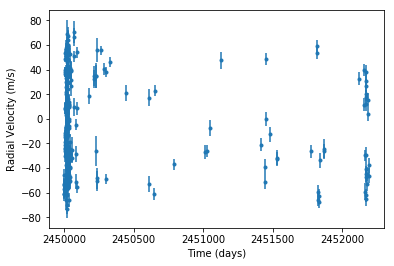

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Read the data from file
data = np.genfromtxt("UID_0113357_RVC_001.tbl")

# Define axes
time = data[:,0]
rad_velocity = data[:,1]

# errorbar expects array of shape 2xN and not Nx2 (N = len(x)) for xerr and yerr
# Use the .T method to get the transpose of the matrix
yerror= data[:, 2].T

# Plot radial velocity vs time
plt.xlabel("Time (days)")
plt.ylabel("Radial Velocity (m/s)")

plt.errorbar(time, rad_velocity, yerr=yerror, fmt=".")

Use a **periodogram algorithm** to find the period of our time series

Minimum length: 2141.106648514847
found at index: 4637
and corresponds to a period of: 8.462384403903696
The actual period that corresponds to the first minimum is: 4.231192201951848


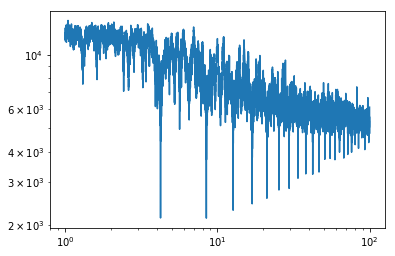

In [2]:

def pathlength(phi,v):
    """
    Calculates the length of a line that would join all the points.
    It takes two sorted lists (phase and velocity) as mandarory arguments
    """
    return sum(
        ((phi_i1 - phi_i)**2 + (v_i1 - v_i)**2)**.5 
        for (phi_i, phi_i1, v_i, v_i1) in zip(phi[1:], phi[:-1], v[1:], v[:-1]))


string_lengths=[] # A list that contains the string length for each period
periods = [] # A list that contains 10,000 periods

for period in np.logspace(0, 2, num = 10000):

    # Define the phase
    phase = (time % period) / period
    periods.append(period)

    # Sort phase and velocity by this phase
    phase_sorted = phase[np.argsort(phase)]
    velocity_sorted = rad_velocity[np.argsort(phase)]
    
    # Do the same for the errors
    errors_sorted = yerror[np.argsort(phase)]
    
    string_lengths.append(pathlength(phase_sorted, velocity_sorted))

# Convert the lists into arrays
periods_array = np.asarray(periods)
string_lengths_array = np.asarray(string_lengths)

# Find the minimum length
print("Minimum length:", min(string_lengths_array))

# and its corresponding index
print("found at index:", np.argmin(string_lengths_array))

# Find the corresponding period
print("and corresponds to a period of:", periods_array[4637])

# Plot a log-log diagram of the string length versus the period
plt.xscale("log")
plt.yscale("log")
plt.plot(periods_array, string_lengths_array)

#NOTE: This period corresponds to the second minimum! Thus,
# for the first minimum the period will be ~ 4.23 days

orbital_period = periods_array[4637] / 2.0

print("The actual period that corresponds to the first minimum is:", orbital_period)


<ErrorbarContainer object of 3 artists>

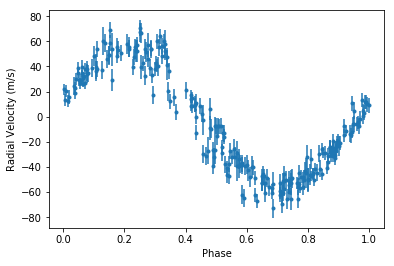

In [3]:
# Re-evaluate and re-sort the phase and velocity for the period we found above

final_phase = (time % (periods_array[4637] / 2.0)) / (periods_array[4637] / 2.0)
final_phase_sorted = final_phase[np.argsort(final_phase)]

final_velocity_sorted = rad_velocity[np.argsort(final_phase)]

# Do the same for the errors
final_errors_sorted = yerror[np.argsort(final_phase)]

# Plot radial velocity (with error bars) versus phase 
plt.xlabel("Phase")
plt.ylabel("Radial Velocity (m/s)")
plt.errorbar(final_phase_sorted, final_velocity_sorted, yerr = yerror, fmt=".")

**Fit the radial velocity versus phase** using a function of the form:

$$f(x) = a \sin{(2\pi x + b)}$$

[ 55.68340868 -12.2867815 ] [[2.70136280e-01 7.80205870e-05]
 [7.80205870e-05 8.64230144e-05]]
a = 55.683409 +/- 0.519746
b = -12.286781 +/- 0.009296


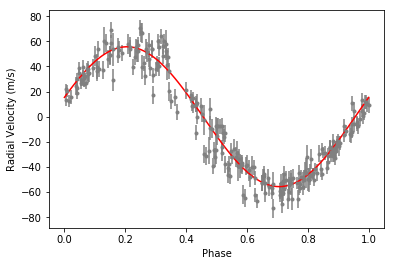

In [4]:
import scipy.optimize as so

def fit_function(x, a, b):
    """
    Fitting function. This applies for one period!
    If you want to fit two peaks then change the
    frequency to 4*np.pi etc.
    """
    return a * np.sin(2 * np.pi * x + b)

# Fit the data
popt, pcov = so.curve_fit(fit_function, final_phase_sorted, final_velocity_sorted,
                        sigma = final_errors_sorted, absolute_sigma = True)


#popt, pcov = so.curve_fit(fit_function, final_phase_sorted, final_velocity_sorted, p0 = (65.234, 3.032),
#                         sigma = yerror, absolute_sigma = True)

print(popt, pcov)
print("a = %f +/- %f" % (popt[0], np.sqrt(pcov[0][0])))
print("b = %f +/- %f" % (popt[1], np.sqrt(pcov[1][1])))

x_fit = np.linspace(0.0, 1.0, 100)
y_fit = fit_function(x_fit, *(popt))

# Making the plot easier to the eye
plt.xlabel("Phase")
plt.ylabel("Radial Velocity (m/s)")

# Plot data with errorbars
plt.errorbar(final_phase_sorted, final_velocity_sorted, yerr = yerror, fmt=".", color="grey")

# Plot fit curve
plt.plot(x_fit, y_fit, 'red')


## Part 2 - Mass analysis of the extrasolar planet *51 Peg b*

Determination of the **mass** of the companion object

In [5]:
# Declare some useful constants
G = 6.674 * 10 ** (-11) # In SI units
M_star = 1.989 * 10 ** (30) # In Kilograms
M_jupiter = 1.898 * 10 ** (27) # In Kilograms


def kepler(M, T = 365472, k = 55.68, i = 90 * np.pi / 180) :
    """
    The inclination angle is provided in degrees and converted
    to radians. The period T has been converted to seconds in
    order for all parameters to comply with SI units.
    """
    global G
    q = ((T / (2 * np.pi * G * M)) ** (1/3)) * (k / np.sin(i))
    return q

# Find the mass ratio
q = kepler(M_star)
print("The mass ratio of the two bodies is:", q)

# Find the mass in kilograms
M_obj_kilo = q * M_star # In kilograms
print("The mass of the companion is:", M_obj_kilo, "Kilograms")

# Find the mass in units of Jupiter masses
M_obj_jup = M_obj_kilo / M_jupiter
print("or", M_obj_jup, "times the mass of Jupiter")

# The object is likely a small planet orbiting a Sun-like star
# with an orbiting period of approximately 4.2 days!

The mass ratio of the two bodies is: 0.00042291229569867573
The mass of the companion is: 8.411725561446662e+26 Kilograms
or 0.4431889126157356 times the mass of Jupiter


**Error propagation with Monte Carlo**

Gaussian distribution for Radial Velocity

/Users/SavvasGCh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Gaussian distribution for radial velocity')

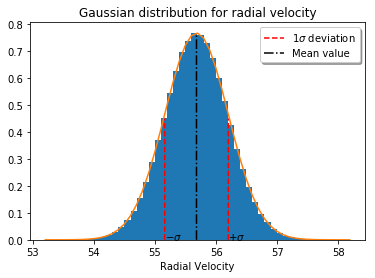

In [6]:
n = 1000000
mean_rad_velocity = 55.68
sigma_rad_velocity = 0.52

# Sample radial velocity
radial_velocity_sample = np.random.normal(mean_rad_velocity, sigma_rad_velocity, n)
    
# Plot histogram and fitting curve    
count, bins, ignored = plt.hist(radial_velocity_sample, 50, normed = True)
plt.plot(bins, 1/(sigma_rad_velocity * np.sqrt(2 * np.pi)) *
        np.exp(- (bins - mean_rad_velocity)**2 / (2 * sigma_rad_velocity ** 2)))


# Axis label
plt.xlabel("Radial Velocity")

# Visualize one sigma deviation
minus_one_sigma = np.ones(n) * (mean_rad_velocity - np.std(radial_velocity_sample, ddof = 1))
plus_one_sigma = np.ones(n) * (mean_rad_velocity + np.std(radial_velocity_sample, ddof = 1))
y = np.linspace(0, 0.45, n)
plt.plot(minus_one_sigma, y, "--", color = "red", label = r"$1\sigma$ deviation")
plt.plot(plus_one_sigma, y, '--', color = "red")

# Visualize mean value
mean_value = np.ones(n) * np.mean(radial_velocity_sample) 
y2 = np.linspace(0, 0.76, n)
plt.plot(mean_value, y2, "-.", color = "black", label = "Mean value")

# Legend and text
legend = plt.legend(loc = "upper right", shadow = True)
plt.text(minus_one_sigma[0], y[1], r"$-\sigma$")
plt.text(plus_one_sigma[0], y[1], r"$+\sigma$")
plt.title("Gaussian distribution for radial velocity")



Uniform distribution for the Mass of the star

/Users/SavvasGCh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Uniform distribution for the mass of the star')

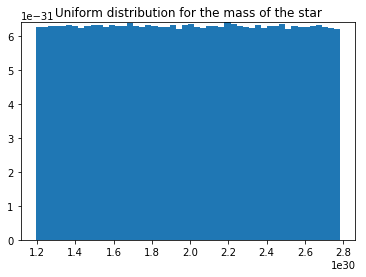

In [7]:
# Sample of masses in solar mass units
mass_sample = np.random.uniform((0.6 * M_star), (1.4 * M_star), n)

# Plot histogram
count, bins, ignored = plt.hist(mass_sample, 50, normed = True)
plt.title("Uniform distribution for the mass of the star")


Distribution for $sin(i)$

/Users/SavvasGCh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of $\\sin(i)$')

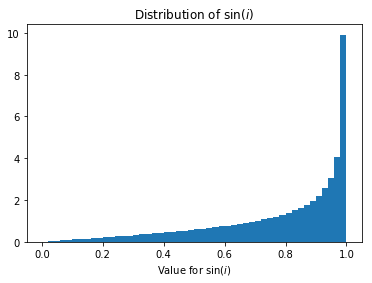

In [8]:
# Sample for cosine
cos_sample = np.random.uniform(0,1, n)

# The uniform distribution for cosine:
#count, bins, ignored = plt.hist(cos_sample, 50, normed = True)

# Sample for sine
# Here we're using the basic trigonometric identity
# sin(x)^2 + cos(x)^2 = 1
sin_sample = np.sqrt(1 - cos_sample ** 2)

# Plot histogram
count, bins, ignored = plt.hist(sin_sample, 50, normed = True)
plt.xlabel(r"Value for $\sin(i)$")
plt.title(r"Distribution of $\sin(i)$")

Histogram of the probability the object to have a certain mass

/Users/SavvasGCh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of masses for the companion object')

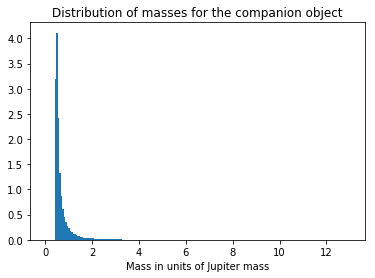

In [9]:
# Use the previous non-gaussian distributions/samples to 
# simulate the q-ratio
final_q =  ((365472 / (2 * np.pi * G * mass_sample)) ** (1/3)) * (radial_velocity_sample / sin_sample)

# Convert the x-axis to reflect the mass of the
# object in units of Jupiter mass
M_obj_in_jup_unit = (final_q * M_star) / M_jupiter

# Plot the histogram constraining the x-axis to 0-13 times Jupiter's mass
count, bins, ignored = plt.hist(M_obj_in_jup_unit, 200, range = (0.0, 13.0), normed = True)
plt.xlabel("Mass in units of Jupiter mass")
plt.title("Distribution of masses for the companion object")


Calculation of the **probability** that the object is less massive than 13 times the mass of Jupiter

In [ ]:
import sympy as s
from sympy.abc import sigma

# Create a mask (boolean array) for the masses that are
# above the maximum mass of a planet
mask_for_non_planet = M_obj_in_jup_unit > 13.0

# Check how many values (out of one million) exceed
# the maximum limit
more_than_13_mass = M_obj_in_jup_unit[mask_for_non_planet]
#print(len(more_than_13_mass))

# Calculate the probability a value would exceed this
# limit
prob_no_planet = (len(more_than_13_mass) / n) * 100
prob_planet = 100 - prob_no_planet

# Print final results
print("The probability of the object to be a planet is", str(round(prob_planet, 4)) + "%")
print("This corresponds to an approximate 3.4" + str(s.pretty(sigma)), "confidence level")

COMMENTS:

Based on the final results, we can be 99.9% positive that the orbiting object is a planet.
The mass of the planet is difficult to be constrained due to uncertainties, but the most
probable scenario is that it has a mass around 0.44 times the mass of Jupiter.